In [6]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
my_palette = sns.color_palette("husl")
my_palette.pop(1)
sns.set_palette(sns.color_palette(my_palette))
register_matplotlib_converters()

## Data Exploration

In [2]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "6", "14", "35", "37", "69", "328"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["6"] = b_6
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69

def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    print(df['bus_stop_name'].unique())
    df.head()
    return df

In [3]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (22860, 6)
["Ladbroke Grove Sainsbury's" 'Silverthorne Road'
 'Knightsbridge Station  / Harrods' 'Prince Of Wales Gate' 'Ladbroke Road'
 'Notting Hill Gate Station' 'Pont Street' 'Knightsbridge Station'
 'Kensington Church Street / Holland St' 'Vauxhall Bus Station'
 'Battersea Park Station' 'Cedars Road' 'Kilburn Lane / Harrow Road'
 'Kensal House' 'Ladbroke Grove Station' "Queen's Gate" 'Sopwith Way'
 'Queenstown Road / Wandsworth Road' 'Sheffield Terrace' 'Chesterton Road'
 'Union Road' 'The Chase' 'Kensal Rise Station'
 'Sloane Street / Knightsbridge Station' 'Battersea Park / Chelsea Gate'
 'Royal Albert Hall' 'Wandsworth Road Station' 'Rutland Gardens'
 'Queenstown Road Station' 'Royal Hospital Road' 'Knightsbridge Barracks'
 'Barlby Road' 'Prairie Street' 'Covent Garden Market East Side'
 'Larkhall Park' 'Lister Hospital' 'Harrow Road / Kilburn Lane'
 'Banister Road' 'Stanley Gardens' 'Palace Gate' 'St Charles Square'
 'Lansdowne Green' 'Sloane Square Stn

In [4]:
def spread_of_time(df, route):
    hour_min = [x[11:15] + '0' for x in df['expected_arrival']]
    for_aggr = df.assign(hour_min = hour_min)
    for_aggr = for_aggr.groupby('hour_min').count().reset_index()

    arrival_times = [dt.datetime.strptime(time, '%H:%M') for time in for_aggr['hour_min']]

    fig, ax = plt.subplots(figsize=(13, 5))
    ax.plot(arrival_times, for_aggr['bus_stop_name'])
    ax.set_title("Spread of time of data collected for bus route {}".format(route))
    ax.set_xlim(dt.datetime.strptime('00:00', '%H:%M'), dt.datetime.strptime('23:59', '%H:%M'))
    date_form = DateFormatter("%H-%M")
    ax.xaxis.set_major_formatter(date_form)
    ax.set_xlabel("Time of day")
    ax.set_ylabel("Occurences")
    plt.show()

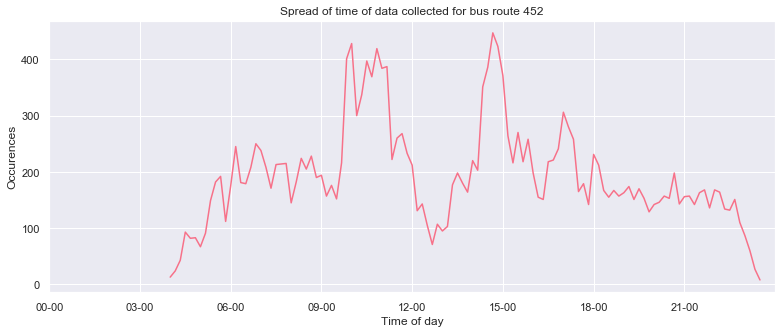

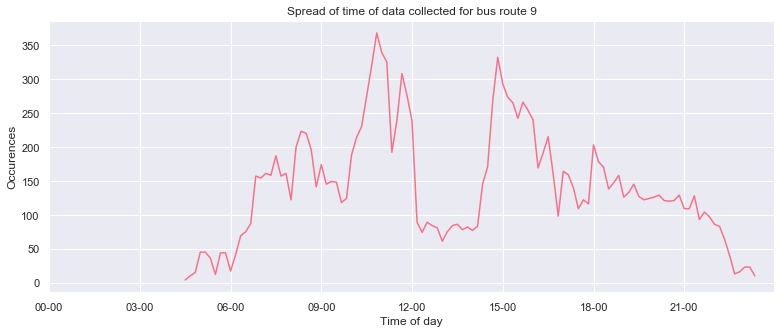

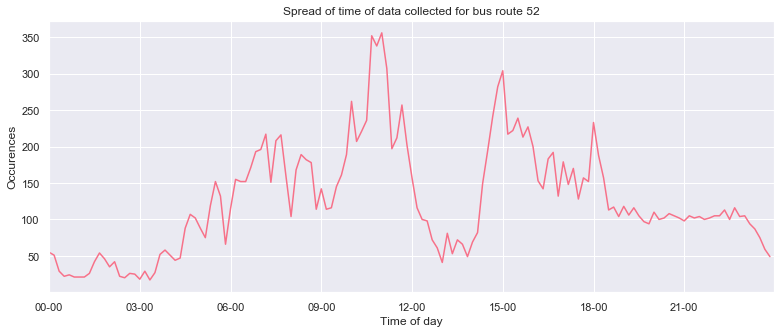

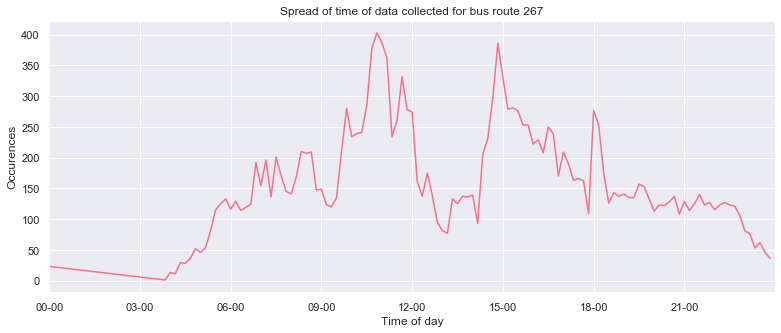

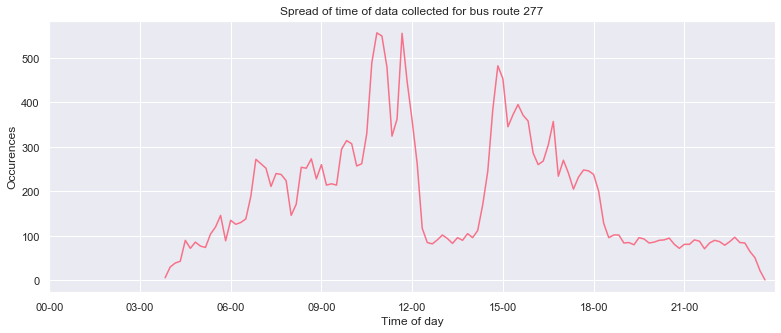

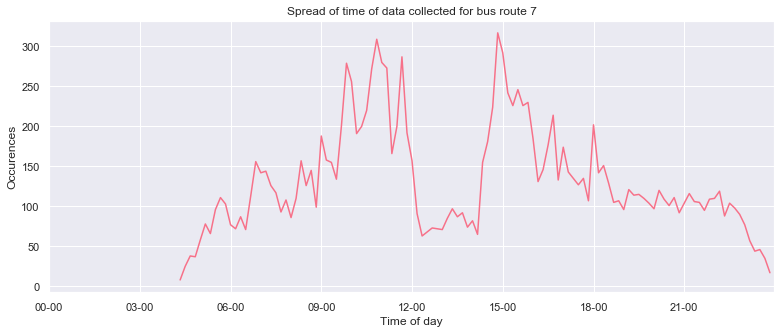

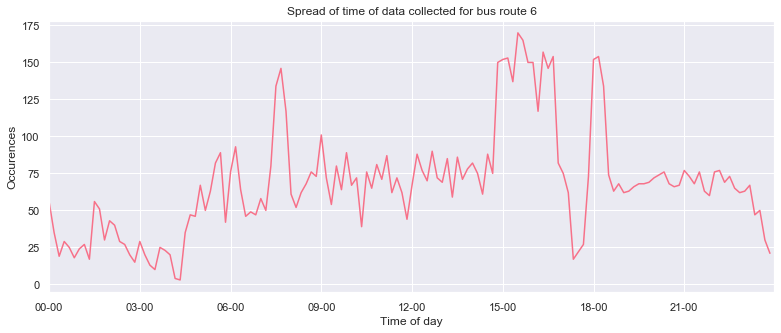

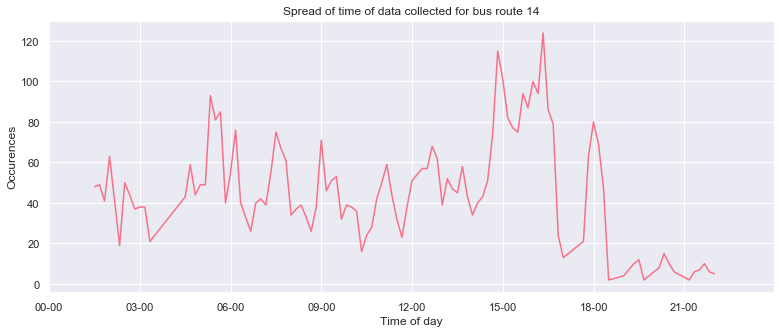

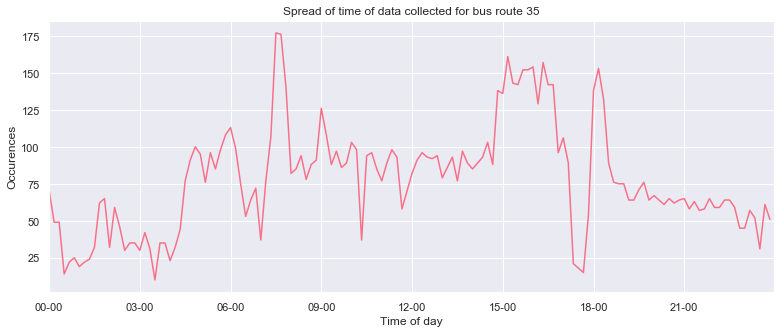

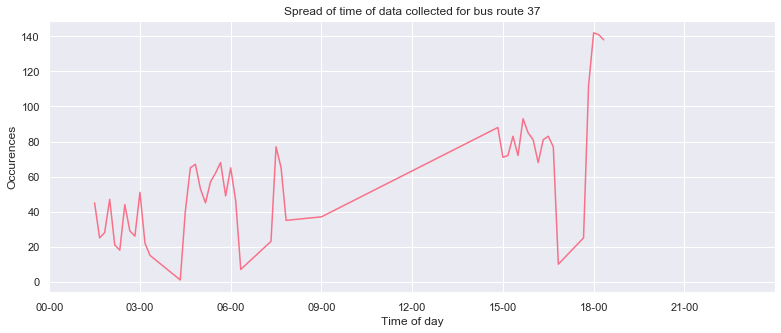

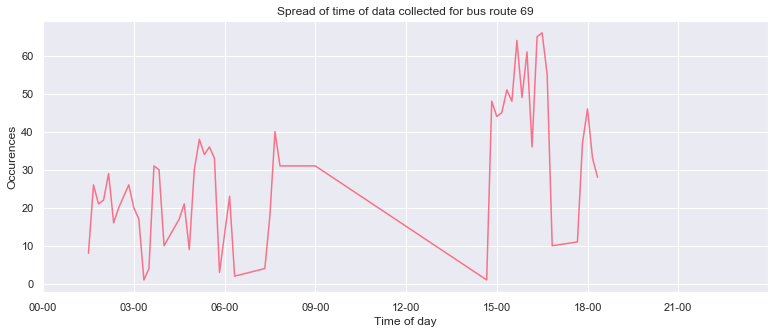

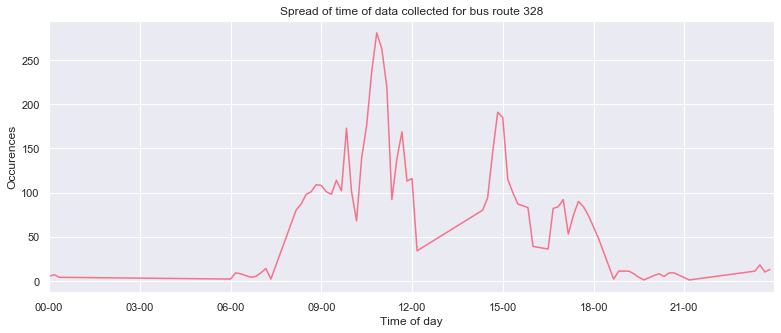

In [7]:
for route in routes:
    spread_of_time(data[route], route)

In [8]:
def spread_of_day_of_week(df, route):

    day_of_week = [x[:10] for x in df['expected_arrival']]
    day_of_week = [dt.datetime.strptime(date, '%Y-%m-%d') for date in day_of_week]

    day_of_week = [calendar.day_name[date.weekday()] for date in day_of_week]
    for_aggr = df.assign(day_of_week = day_of_week)
    for_aggr = for_aggr.groupby('day_of_week').count().reset_index()

    fig, ax = plt.subplots(figsize=(13, 5))
    ax.plot(for_aggr['day_of_week'], for_aggr['bus_stop_name'])
    ax.set_title("Spread of days of the week for data collected for route {}".format(route))
    ax.set_ylim(0)
    ax.set_xlabel("Day of Week")
    ax.set_ylabel("Occurences")
    plt.show()

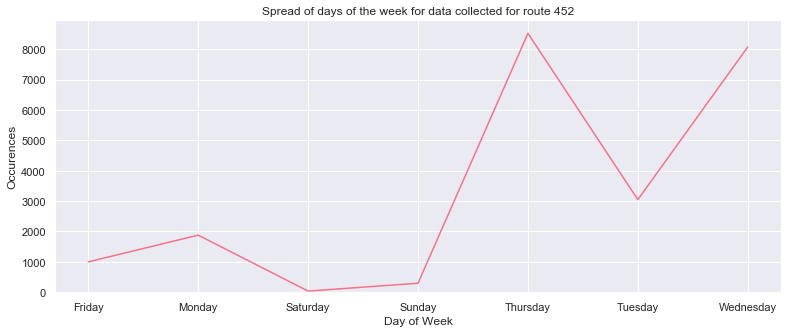

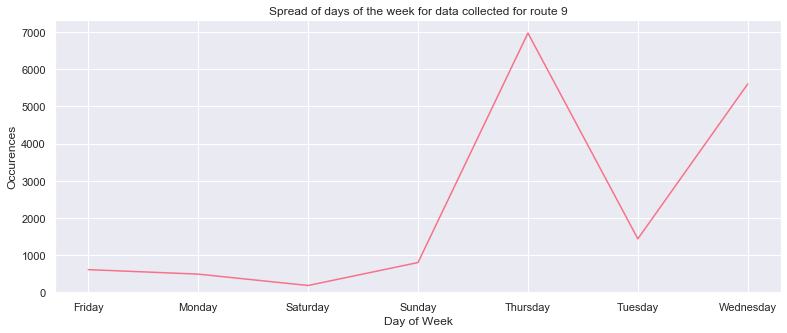

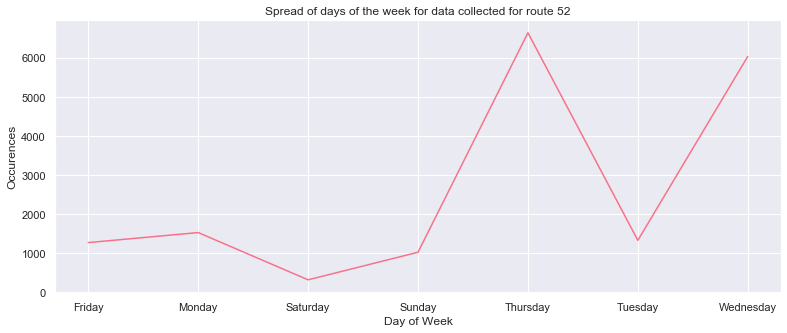

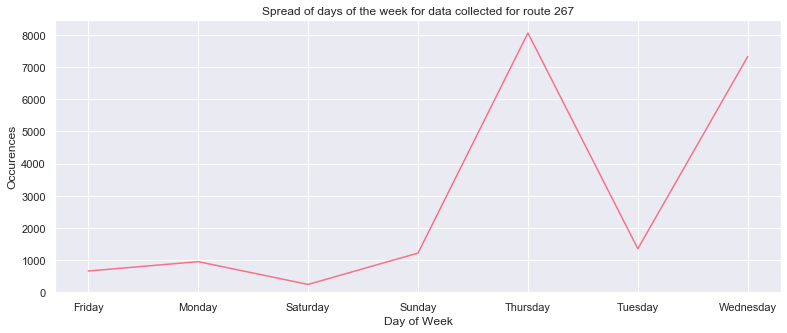

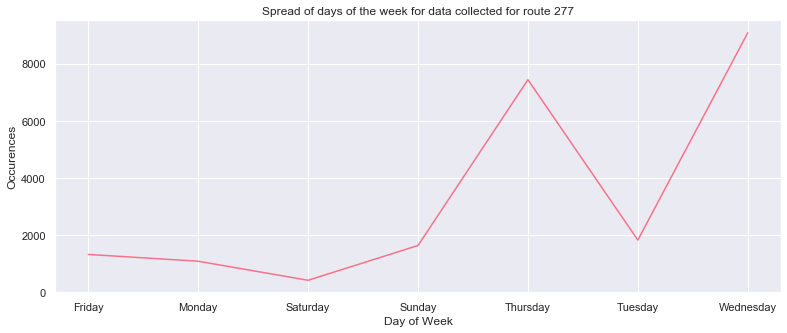

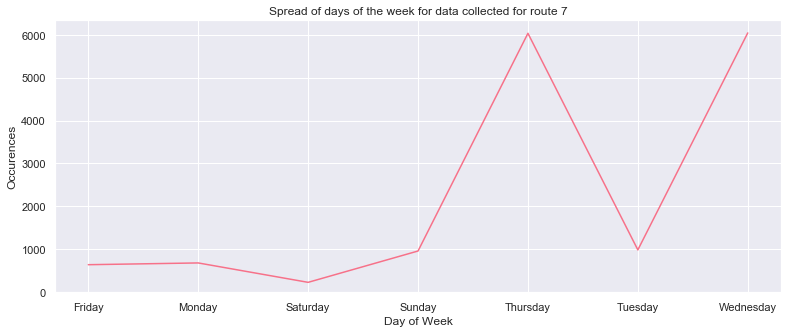

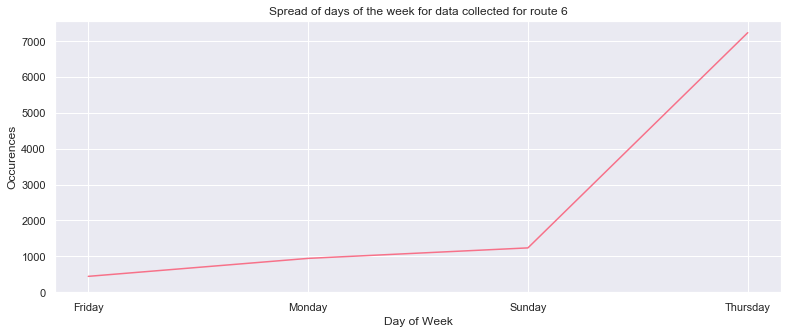

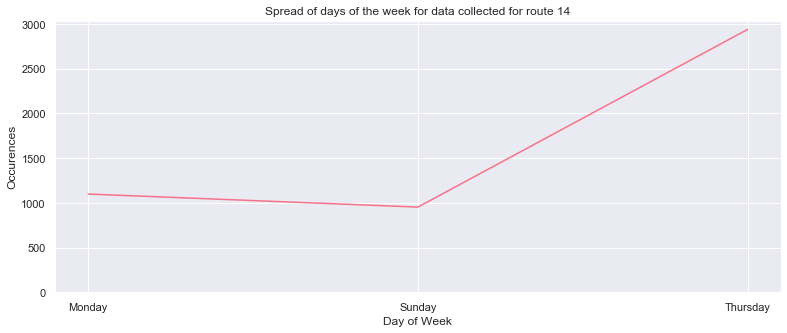

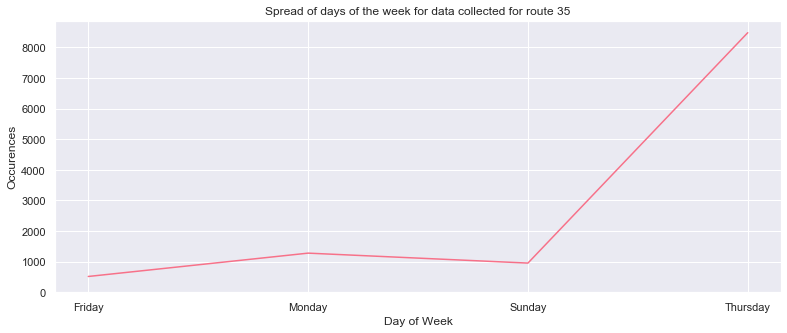

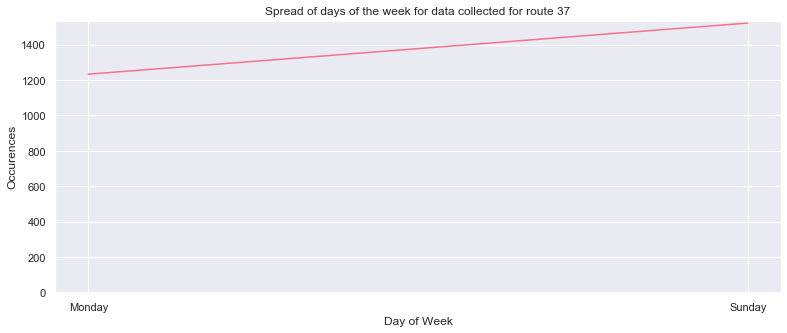

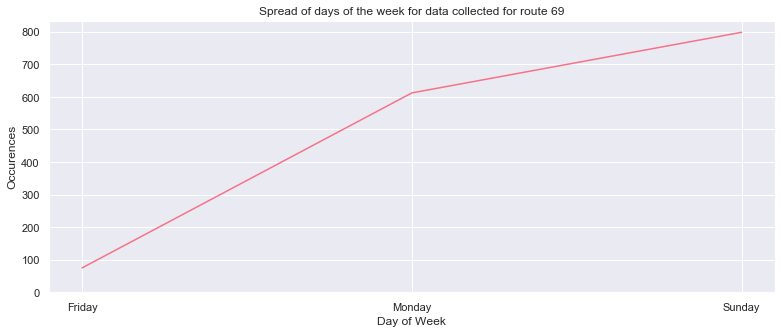

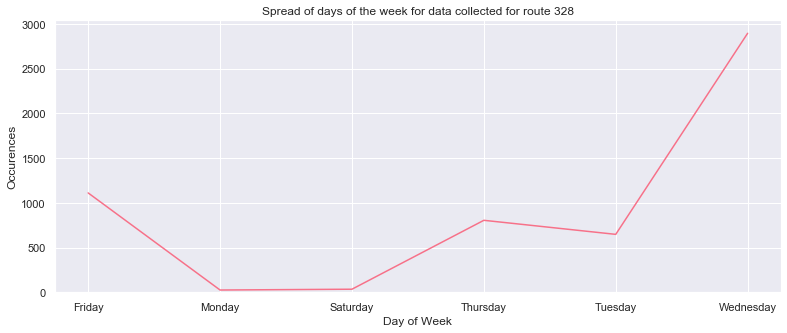

In [9]:
for route in routes:
    spread_of_day_of_week(data[route], route)

### Try to see if I can get the average time taken for a bus to travel between "Vauxhall Bus Station" and "Battersea Park Station" (inbound)

In [10]:
b_452 = data["452"]
vauxhall = b_452.loc[(b_452['bus_stop_name'] == 'Vauxhall Bus Station') & (b_452['direction'] == 'in')]
[_, vauxhall_id, _, _, _] = vauxhall.iloc[0]['vehicle_id'].split('_')
print(vauxhall.shape)
print(vauxhall_id)
vauxhall.head()

(249, 5)
490000247G1


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
11,Vauxhall Bus Station,2020-04-02 17:07:31,20189_490000247G1_2020-04-02_in_2,2020-04-02 16:49:18,in
48,Vauxhall Bus Station,2020-03-30 05:52:51,20191_490000247G1_2020-03-30_in_0,2020-03-30 05:28:43,in
76,Vauxhall Bus Station,2020-03-30 07:11:46,20310_490000247G1_2020-03-30_in_0,2020-03-30 06:43:43,in
151,Vauxhall Bus Station,2020-04-02 22:51:27,20199_490000247G1_2020-04-02_in_8,2020-04-02 22:51:37,in
292,Vauxhall Bus Station,2020-04-02 22:39:01,20278_490000247G1_2020-04-02_in_7,2020-04-02 22:36:37,in


In [11]:
battersea_prk_st = b_452.loc[(b_452['bus_stop_name'] == 'Battersea Park Station') & (b_452['direction'] == 'in')]
[_, battersea_prk_st_id, _, _, _] = battersea_prk_st.iloc[0]['vehicle_id'].split('_')
print(battersea_prk_st.shape)
print(battersea_prk_st_id)
battersea_prk_st.head()

(259, 5)
490G01016A


,bus_stop_name,expected_arrival,vehicle_id,time_of_req,direction
12,Battersea Park Station,2020-04-02 13:18:42,20189_490G01016A_2020-04-02_in_0,2020-04-02 13:16:44,in
13,Battersea Park Station,2020-04-01 10:27:00,20271_490G01016A_2020-04-01_in_0,2020-04-01 10:26:42,in
34,Battersea Park Station,2020-04-01 09:53:39,20196_490G01016A_2020-04-01_in_0,2020-04-01 09:53:03,in
37,Battersea Park Station,2020-04-06 07:36:56,20314_490G01016A_2020-04-06_in_1,2020-04-06 07:27:02,in
84,Battersea Park Station,2020-04-02 05:41:12,20193_490G01016A_2020-04-02_in_0,2020-04-02 05:34:44,in


In [28]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time

# split times into groups: 00-03, 03-06, 06-09, 09-12, 12-15, 15-18, 18-21, 21-00
# def get_time_of_day_group(given_time):
#     hour = int(given_time[11:13])
#     if (hour < 3) & (hour >= 0):
#         return "00"
#     elif (hour < 6) & (hour >= 3):
#         return "03"
#     elif (hour < 9) & (hour >= 6):
#         return "06"
#     elif (hour < 12) & (hour >= 9):
#         return "09"
#     elif (hour < 15) & (hour >= 12):
#         return "12"
#     elif (hour < 18) & (hour >= 15):
#         return "15"
#     elif (hour < 21) & (hour >= 18):
#         return "18"
#     elif hour >= 21:
#         return "21"
    
def get_time_of_day_group(given_time):
    hour = int(given_time[11:13])
    if (hour < 3) & (hour >= 0):
        return 0
    elif (hour < 6) & (hour >= 3):
        return 1
    elif (hour < 9) & (hour >= 6):
        return 2
    elif (hour < 12) & (hour >= 9):
        return 3
    elif (hour < 15) & (hour >= 12):
        return 4
    elif (hour < 18) & (hour >= 15):
        return 5
    elif (hour < 21) & (hour >= 18):
        return 6
    elif hour >= 21:
        return 7
    
colour_to_time_label = ["00-03", "03-06", "06-09", "09-12", "12-15", "15-18", "18-21", "21-00"]

In [13]:
journey_times = []
# time_of_day = {"00": [], "03": [], "06": [], "09": [], "12": [], "15": [], "18":[], "21":[]}
labels = []

a = time.time()
for i, journey in battersea_prk_st.iterrows():
    [bus_id, stop_id, date, direction, num_trip] = journey['vehicle_id'].split('_')
    match_id = bus_id + '_' + vauxhall_id + '_' + date + '_' + direction + '_'
    start = convert_time_to_datetime(journey['expected_arrival'])
    for j, match in vauxhall.iterrows():
        [bus_idx, stop_idx, datex, directionx, num_tripx] = match['vehicle_id'].split('_')
        end = convert_time_to_datetime(match['expected_arrival'])
        if match['vehicle_id'].startswith(match_id):
            if (end - start < dt.timedelta(hours = 1, minutes = 40)) & (end - start > dt.timedelta(minutes = 0)):
                diff = end - start
                journey_times.append(diff)
                section_of_day = get_time_of_day_group(match['expected_arrival'])
                labels.append(section_of_day)
#                 items = time_of_day[section_of_day]
#                 items.append(diff)
#                 time_of_day[section_of_day] = items
                break
                
print("Time taken: ", (time.time() - a))

Time taken:  5.482445001602173


Average travel time between Vauxhall Bus Station and Battersea Park Station is 14.576501501501513 minutes


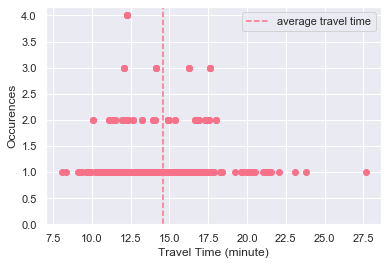

In [14]:
travel_times = [(time.total_seconds() / 60) for time in journey_times]
avg_time = sum(travel_times) / len(travel_times)
print("Average travel time between Vauxhall Bus Station and Battersea Park Station is {} minutes".format(avg_time))

counts = [journey_times.count(elem) for elem in journey_times]

fig, ax = plt.subplots()
ax.scatter(travel_times, counts)
ax.axvline(x = avg_time, linestyle='dashed', label = "average travel time")
ax.set_xlabel("Travel Time (minute)")
ax.set_ylabel("Occurences")
ax.set_ylim(0)
ax.legend()
plt.show()

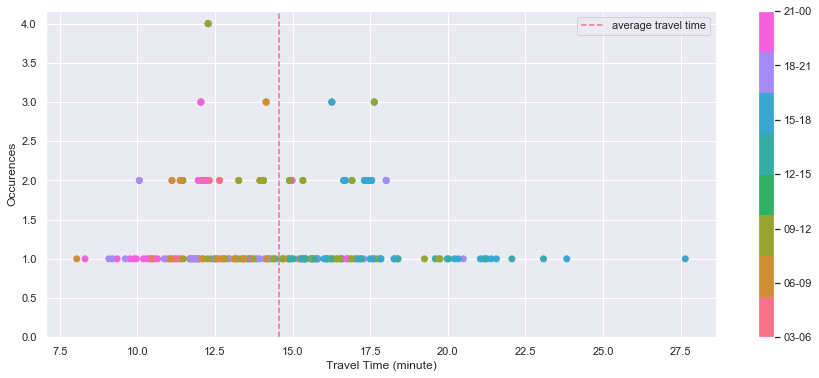

['00-03', '03-06', '06-09', '09-12', '12-15', '15-18', '18-21', '21-00']


In [39]:
colours = sns.color_palette("husl", 8)
colors = [colours[i] for i in range(len(colours))]

fig, ax = plt.subplots(figsize=(15,6))
sctr = ax.scatter(travel_times, counts, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
ax.axvline(x = avg_time, linestyle='dashed', label = "average travel time")
ax.set_xlabel("Travel Time (minute)")
ax.set_ylabel("Occurences")
ax.set_ylim(0)
ax.legend()

cbar = fig.colorbar(sctr, ax=ax)
cbar.set_ticks([0, 1, 2, 3, 4, 5, 6, 7])
cbar.ax.set_yticklabels(colour_to_time_label)

plt.show()

print(colour_to_time_label)

### Try to see if I can get the average time taken for a bus to travel between station A and station B where 2 different bus routes have 2 same stations